# Contrived Notebook 

This contrived notebook shows a few ways to "reuse" Hamilton dataflows.

This is more a notebook to show the mechanics, rather than proper applicability of the approach.

In [94]:
from hamilton import base
from hamilton import driver

import pandas as pd
# load some extensions / magic...
%load_ext hamilton.plugins.jupyter_magic
# load extension
%load_ext autoreload
# configure autoreload to only affect specified files
%autoreload 1

The hamilton.plugins.jupyter_magic extension is already loaded. To reload it, use:
  %reload_ext hamilton.plugins.jupyter_magic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple case

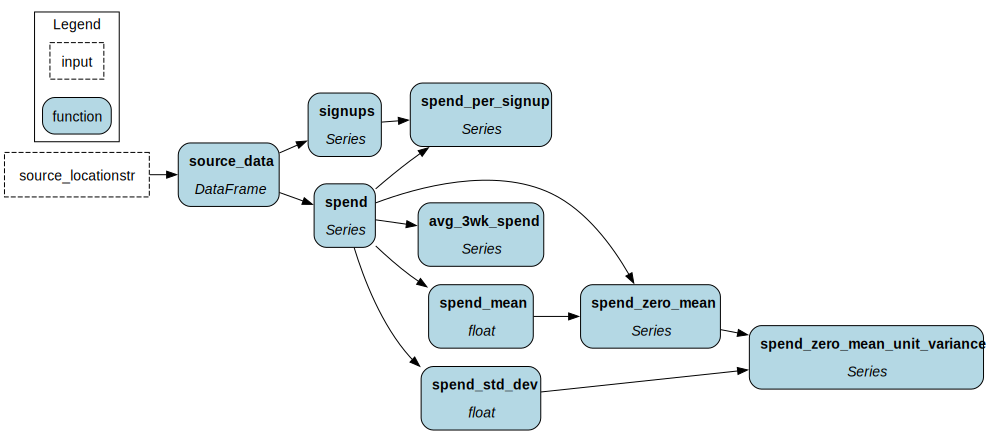

In [14]:
%%cell_to_module -m simple --display
import pandas as pd
from hamilton.function_modifiers import extract_columns

@extract_columns("spend", "signups")
def source_data(source_location: str) -> pd.DataFrame:
    # use source
    return pd.DataFrame({"spend": pd.Series([1,2,3,4]), "signups": pd.Series([10,20,30,40])})


def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

In [15]:
dr_simple = (
    driver.Builder()
    .with_modules(simple)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)
dr_simple.execute(
    ["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"], 
    inputs={"source_location": "db.some_table"}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance
0,1,10,NaN,-1.161895
1,2,20,NaN,-0.387298
2,3,30,2.0,0.387298
3,4,40,3.0,1.161895


## But I have US & UK to process
What if I have different data sources to process?

### Loop over inputs

In [20]:
# Loop
results = []
for source_location in ["US.LOCATION", "UK.LOCATION"]:
    result = dr_simple.execute(
        ["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"], 
        inputs={"source_location": source_location}
    )
    result["location"] = source_location.split(".")[0]
    results.append(result)
    # do something with it
pd.concat(results)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,location
0,1,10,NaN,-1.161895,US
1,2,20,NaN,-0.387298,US
2,3,30,2.0,0.387298,US
3,4,40,3.0,1.161895,US
0,1,10,NaN,-1.161895,UK
1,2,20,NaN,-0.387298,UK
2,3,30,2.0,0.387298,UK
3,4,40,3.0,1.161895,UK


### Hamilton within Hamilton

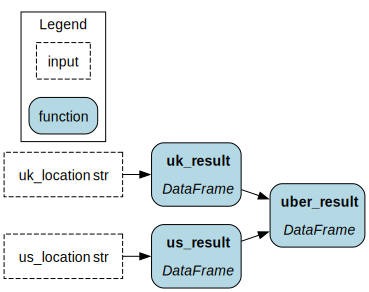

In [100]:
%%cell_to_module -m h_within_h --display
import pandas as pd
from hamilton import driver, base
import simple

def us_result(us_location: str) -> pd.DataFrame:
    dr_simple = (
        driver.Builder()
        .with_modules(simple)
        .with_adapters(base.PandasDataFrameResult())
        .build()
    )
    result = dr_simple.execute(
        ["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"], 
        inputs={"source_location": us_location}
    )
    result["location"] = "US"
    return result

def uk_result(uk_location: str) -> pd.DataFrame:
    dr_simple = (
        driver.Builder()
        .with_modules(simple)
        .with_adapters(base.PandasDataFrameResult())
        .build()
    )
    result = dr_simple.execute(
        ["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"], 
        inputs={"source_location": uk_location}
    )
    result["location"] = "UK"
    return result

def uber_result(us_result: pd.DataFrame, uk_result: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([us_result, uk_result])

In [101]:
dr_h_w_h = (
    driver.Builder()
    .with_modules(h_within_h)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)
dr_h_w_h.execute(
    ["uber_result"], 
    inputs={"us_location": "db.some_table", "uk_location": "db.some_other_table"}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,location
0,1,10,NaN,-1.161895,US
1,2,20,NaN,-0.387298,US
2,3,30,2.0,0.387298,US
3,4,40,3.0,1.161895,US
0,1,10,NaN,-1.161895,UK
1,2,20,NaN,-0.387298,UK
2,3,30,2.0,0.387298,UK
3,4,40,3.0,1.161895,UK


### using subdag
Need to add a result function, because @subdag doesn't currently handle "custom result builders".

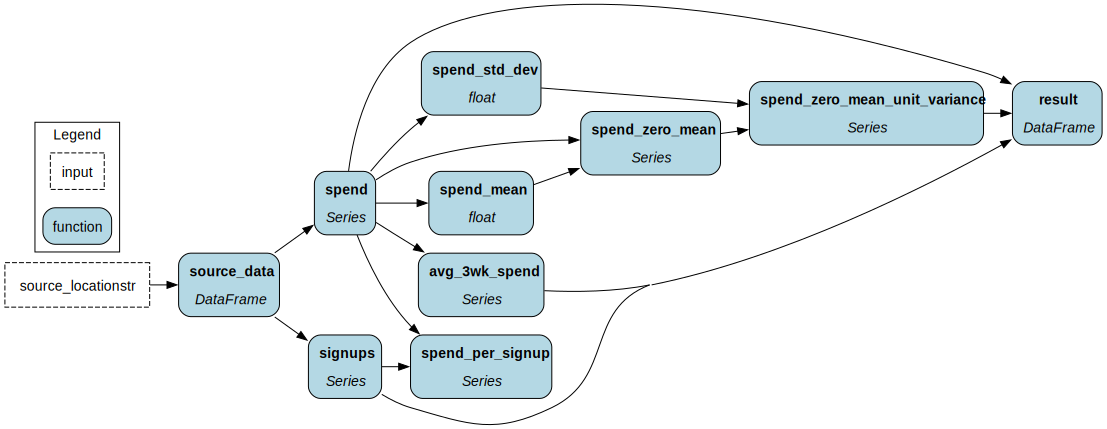

In [21]:
%%cell_to_module -m simple_subdag --display
import pandas as pd
from hamilton.function_modifiers import subdag, extract_columns

@extract_columns("spend", "signups")
def source_data(source_location: str) -> pd.DataFrame:
    # use source
    return pd.DataFrame({"spend": pd.Series([1,2,3,4]), "signups": pd.Series([10,20,30,40])})


def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev


def result(spend: pd.Series, signups: pd.Series, avg_3wk_spend: pd.Series, spend_zero_mean_unit_variance: pd.Series) -> pd.DataFrame:
    return pd.DataFrame(locals())

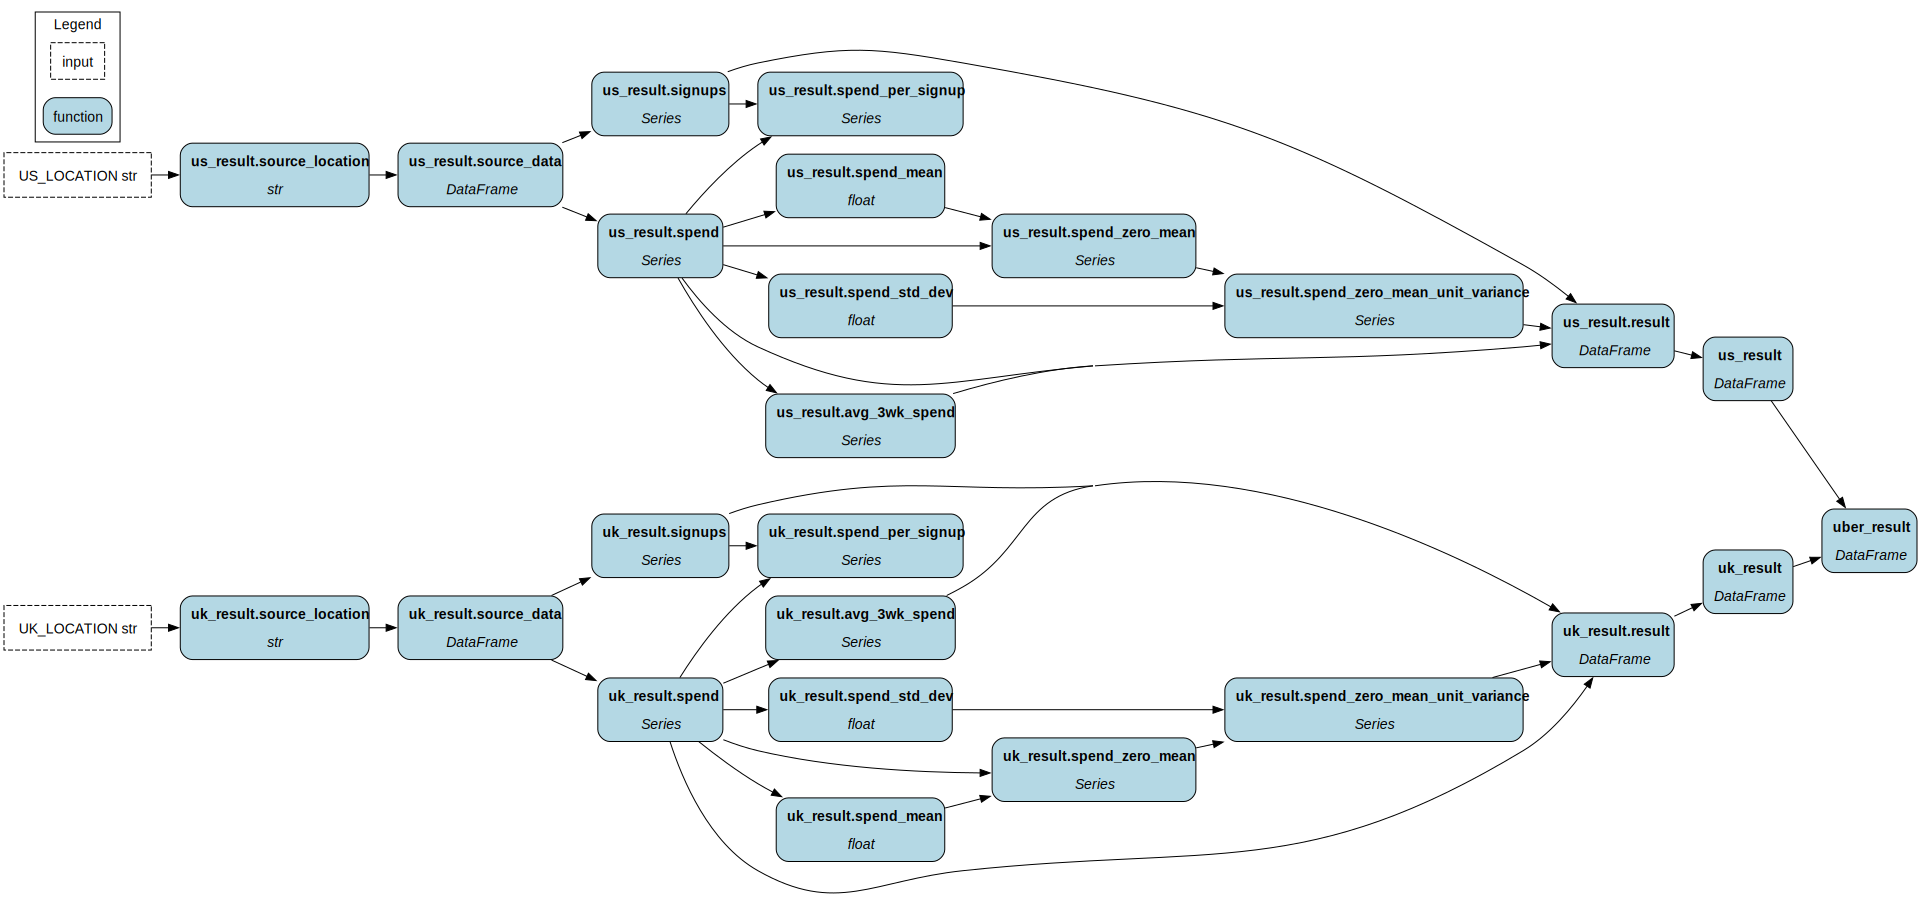

In [28]:
%%cell_to_module -m subdag --display
import pandas as pd
from hamilton.function_modifiers import subdag, extract_columns, source, value
import simple_subdag

@subdag(
    simple_subdag,
    inputs={"source_location": source("US_LOCATION")}
)
def us_result(result: pd.DataFrame) -> pd.DataFrame:
    result["location"] = "US"
    return result

@subdag(
    simple_subdag,
    inputs={"source_location": source("UK_LOCATION")}
)
def uk_result(result: pd.DataFrame) -> pd.DataFrame:
    result["location"] = "UK"
    return result

def uber_result(us_result: pd.DataFrame, uk_result: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([us_result, uk_result])

In [29]:
dr_subdag = (
    driver.Builder()
    .with_modules(subdag)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)
dr_subdag.execute(
    ["uber_result"], 
    inputs={"US_LOCATION": "...", "UK_LOCATION": "..."}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,location
0,1,10,NaN,-1.161895,US
1,2,20,NaN,-0.387298,US
2,3,30,2.0,0.387298,US
3,4,40,3.0,1.161895,US
0,1,10,NaN,-1.161895,UK
1,2,20,NaN,-0.387298,UK
2,3,30,2.0,0.387298,UK
3,4,40,3.0,1.161895,UK


## Custom Result Builder
We can customize the "reduce" step. That is do something with everything that was
requested as output.

In [39]:
from hamilton import lifecycle
import pandas as pd
from typing import Dict, Any, List, Type

class CustomDFResult(lifecycle.ResultBuilder):
    """Example of a custom result builder that one could create."""

    def __init__(self, some_value: int):
        self.value = some_value

    def build_result(self, **outputs: Dict[str, Any]) -> pd.DataFrame:
        # some type checking/processing logic, etc
        print(self.value)
        return pd.concat(outputs.values())

    def input_types(self) -> List[Type[Type]]:
        """Currently this just shoves anything into a dataframe. We should probably
        tighten this up."""
        return [pd.DataFrame]
    
    def output_type(self) -> Type:
        return pd.DataFrame

dr_subdag_custom_builder = (
    driver.Builder()
    .with_modules(subdag)
    .with_adapters(CustomDFResult(42))
    .build()
)
dr_subdag_custom_builder.execute(
    ["us_result", "uk_result"], 
    inputs={"US_LOCATION": "...", "UK_LOCATION": "..."}
)

42


,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,location
0,1,10,NaN,-1.161895,US
1,2,20,NaN,-0.387298,US
2,3,30,2.0,0.387298,US
3,4,40,3.0,1.161895,US
0,1,10,NaN,-1.161895,UK
1,2,20,NaN,-0.387298,UK
2,3,30,2.0,0.387298,UK
3,4,40,3.0,1.161895,UK


## Something Dynamic: Parallelizable + Collect

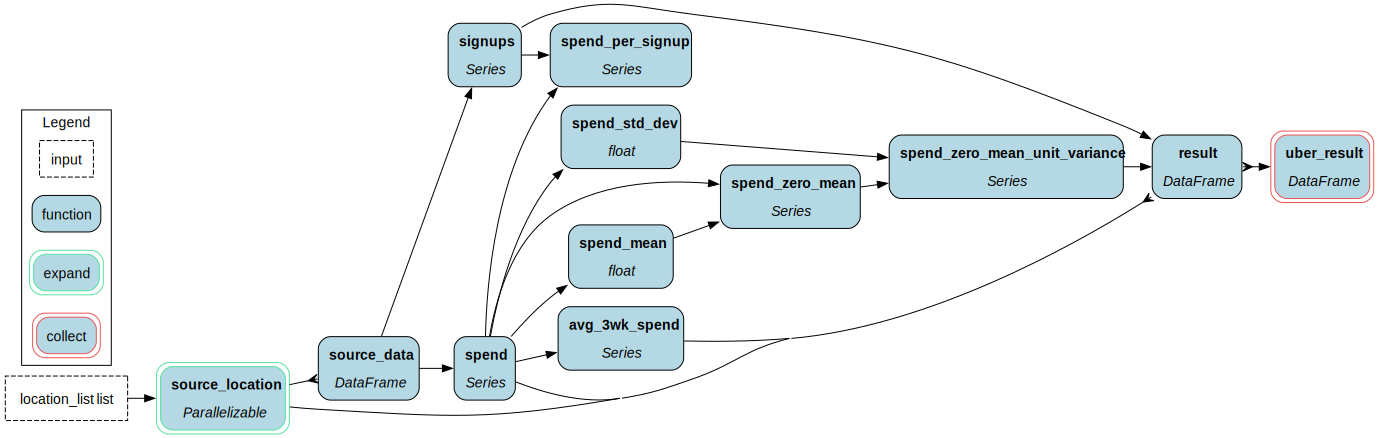

In [46]:
%%cell_to_module -m parallel_collect --display
import pandas as pd
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import subdag, extract_columns

def source_location(location_list: list[str]) -> Parallelizable[str]:
    for loc in location_list:
        yield loc

@extract_columns("spend", "signups")
def source_data(source_location: str) -> pd.DataFrame:
    # use source
    return pd.DataFrame({"spend": pd.Series([1,2,3,4]), "signups": pd.Series([10,20,30,40])})


def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev


def result(spend: pd.Series, signups: pd.Series, avg_3wk_spend: pd.Series, spend_zero_mean_unit_variance: pd.Series, source_location: str) -> pd.DataFrame:
    return pd.DataFrame(locals())

def uber_result(result: Collect[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(result)

In [65]:
dr_parallel = (
    driver.Builder()
    .with_modules(parallel_collect)
    .with_adapters(base.PandasDataFrameResult())
    .enable_dynamic_execution(allow_experimental_mode=True) 
    .build()
)
dr_parallel.execute(
    ["uber_result"], 
    inputs={"location_list": ["US_LOCATION", "UK_LOCATION"]}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,source_location
0,1,10,NaN,-1.161895,US_LOCATION
1,2,20,NaN,-0.387298,US_LOCATION
2,3,30,2.0,0.387298,US_LOCATION
3,4,40,3.0,1.161895,US_LOCATION
0,1,10,NaN,-1.161895,UK_LOCATION
1,2,20,NaN,-0.387298,UK_LOCATION
2,3,30,2.0,0.387298,UK_LOCATION
3,4,40,3.0,1.161895,UK_LOCATION


## But what if I want the columns returned to be more dynamic?
@resolve + @inject! 

In [61]:
resolve_config = {"columns_wanted":["spend", "signups", "avg_3wk_spend", "spend_zero_mean_unit_variance"], "hamilton.enable_power_user_mode": True}

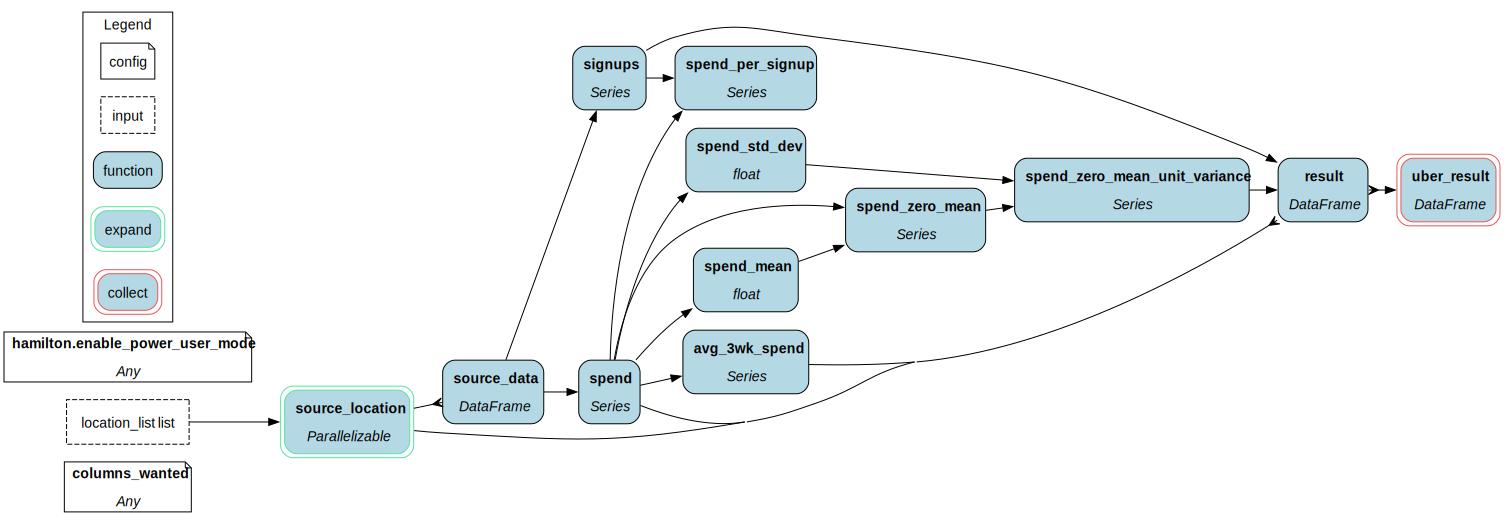

In [62]:
%%cell_to_module -m parallel_resolve_inject --display --config resolve_config
import pandas as pd
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import subdag, extract_columns, resolve, ResolveAt, inject, group, source

def source_location(location_list: list[str]) -> Parallelizable[str]:
    for loc in location_list:
        yield loc

@extract_columns("spend", "signups")
def source_data(source_location: str) -> pd.DataFrame:
    # use source
    return pd.DataFrame({"spend": pd.Series([1,2,3,4]), "signups": pd.Series([10,20,30,40])})


def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev


@resolve(
    when=ResolveAt.CONFIG_AVAILABLE,
    decorate_with=lambda columns_wanted: inject(
        columns=group(
            **{column: source(column) for column in columns_wanted}
        )
    ),
)
def result(columns: dict[str, pd.Series], source_location: str) -> pd.DataFrame:
    columns["source_location"] = source_location
    return pd.DataFrame(columns)

def uber_result(result: Collect[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(result)

In [64]:
dr_parallel_resolve = (
    driver.Builder()
    .with_modules(parallel_resolve_inject)
    .with_config(resolve_config)
    .with_adapters(base.PandasDataFrameResult())
    .enable_dynamic_execution(allow_experimental_mode=True) 
    .build()
)
dr_parallel_resolve.execute(
    ["uber_result"], 
    inputs={"location_list": ["US_LOCATION", "UK_LOCATION"]}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,source_location
0,1,10,NaN,-1.161895,US_LOCATION
1,2,20,NaN,-0.387298,US_LOCATION
2,3,30,2.0,0.387298,US_LOCATION
3,4,40,3.0,1.161895,US_LOCATION
0,1,10,NaN,-1.161895,UK_LOCATION
1,2,20,NaN,-0.387298,UK_LOCATION
2,3,30,2.0,0.387298,UK_LOCATION
3,4,40,3.0,1.161895,UK_LOCATION


## Alternatives to per column processing
Some lazily evaluated DFs can't be split into columns, what are you to do?

> @pipe

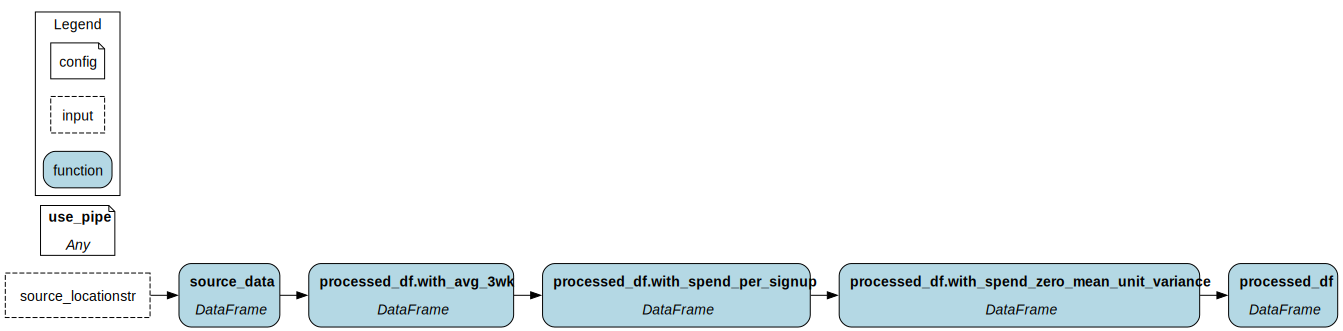

In [81]:
%%cell_to_module -m pipe_module --display --config '{"use_pipe":"TRUE"}'
import pandas as pd
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import step, extract_columns, pipe, value, config


def source_data(source_location: str) -> pd.DataFrame:
    # use source
    return pd.DataFrame({"spend": pd.Series([1,2,3,4]), "signups": pd.Series([10,20,30,40])})


def _avg_3wk(df: pd.DataFrame, col_name: str, output_name: str) -> pd.DataFrame:
    return df.assign(output_name=df[col_name].rolling(3).mean())


def _spend_per_signup(df: pd.DataFrame) -> pd.DataFrame:
    """The cost per signup in relation to spend."""
    return df.assign(spend_per_signup=df.spend / df.signups)


def _spend_zero_mean_unit_variance(df: pd.DataFrame) -> pd.DataFrame:
    """Function showing one way to make spend have zero mean and unit variance."""
    spend_mean = df.spend.mean()
    spend_zero_mean = df.spend - spend_mean
    spend_std_dev = df.spend.std()
    return df.assign(spend_zero_mean_unit_variance=(spend_zero_mean / spend_std_dev))

@config.when(use_pipe="TRUE")
@pipe(
    step(_avg_3wk, col_name="spend", output_name="avg_3wk_spend"),
    step(_spend_per_signup),
    step(_spend_zero_mean_unit_variance),
)
def processed_df__pipe(source_data: pd.DataFrame) -> pd.DataFrame:
    return source_data

@config.when(use_pipe="FALSE")
def processed_df__not_pipe(source_data: pd.DataFrame) -> pd.DataFrame:
    _df = _avg_3wk(source_data, col_name="spend", output_name="avg_3wk_spend")
    _df = _spend_per_signup(_df)
    _df = _spend_zero_mean_unit_variance(_df)
    return _df

# SEE ISSUE: bring @with_columns to all dataframe types.

In [84]:
dr_pipe = (
    driver.Builder()
    .with_modules(pipe_module)
    .with_config({"use_pipe":"TRUE"})
    # .with_config({"use_pipe":"FALSE"})
    .with_adapters(base.PandasDataFrameResult())
    .build()
)
dr_pipe.execute(
    ["processed_df"], 
    inputs={"source_location": "db.some_table"}
)

,spend,signups,output_name,spend_per_signup,spend_zero_mean_unit_variance
0,1,10,NaN,0.1,-1.161895
1,2,20,NaN,0.1,-0.387298
2,3,30,2.0,0.1,0.387298
3,4,40,3.0,0.1,1.161895


## An advanced combination - Parallel with Subdag

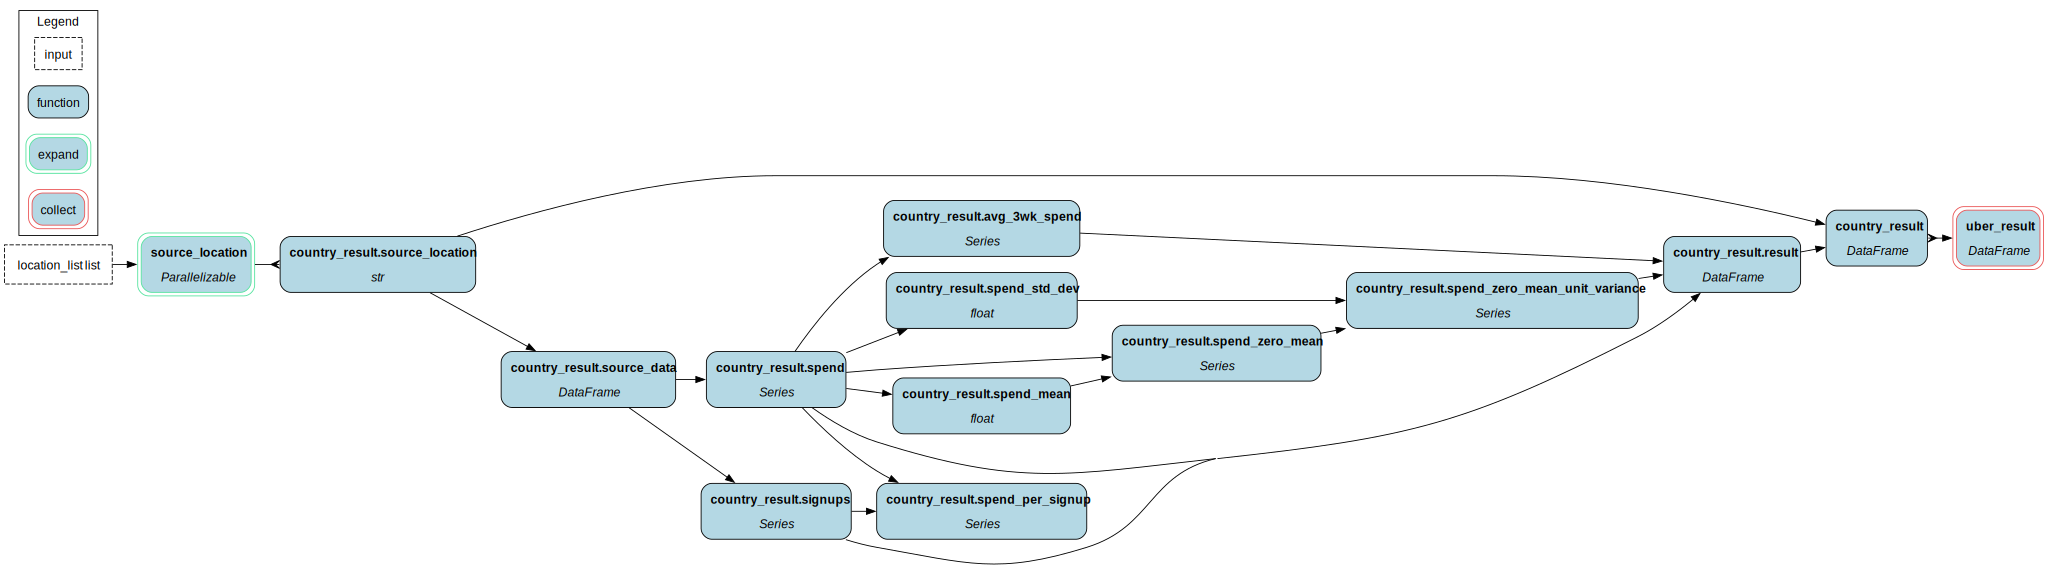

In [86]:
%%cell_to_module -m parallel_subdag --display
import pandas as pd
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import subdag, extract_columns, resolve, ResolveAt, inject, group, source, value
import simple_subdag

def source_location(location_list: list[str]) -> Parallelizable[str]:
    for loc in location_list:
        yield loc

@subdag(
    simple_subdag,
    inputs={"source_location": source("source_location")}
)
def country_result(result: pd.DataFrame, source_location:str) -> pd.DataFrame:
    result["location"] = source_location
    return result


def uber_result(country_result: Collect[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(country_result)

In [87]:
dr_parallel_subdag = (
    driver.Builder()
    .with_modules(parallel_resolve_inject)
    .with_config(resolve_config)
    .with_adapters(base.PandasDataFrameResult())
    .enable_dynamic_execution(allow_experimental_mode=True) 
    .build()
)
dr_parallel_subdag.execute(
    ["uber_result"], 
    inputs={"location_list": ["US_LOCATION", "UK_LOCATION"]}
)

,spend,signups,avg_3wk_spend,spend_zero_mean_unit_variance,source_location
0,1,10,NaN,-1.161895,US_LOCATION
1,2,20,NaN,-0.387298,US_LOCATION
2,3,30,2.0,0.387298,US_LOCATION
3,4,40,3.0,1.161895,US_LOCATION
0,1,10,NaN,-1.161895,UK_LOCATION
1,2,20,NaN,-0.387298,UK_LOCATION
2,3,30,2.0,0.387298,UK_LOCATION
3,4,40,3.0,1.161895,UK_LOCATION
